In [1]:
import numpy as np
import pandas as pd

In [2]:
from io import StringIO
DATA = """Day,Outlook,Temperature,Humidity,Wind,PlayTennis
D1,Sunny,Hot,High,Weak,No
D2,Sunny,Hot,High,Strong,No
D3,Overcast,Hot,High,Weak,Yes
D4,Rain,Mild,High,Weak,Yes
D5,Rain,Cool,Normal,Weak,Yes
D6,Rain,Cool,Normal,Strong,No
D7,Overcast,Cool,Normal,Strong,Yes
D8,Sunny,Mild,High,Weak,No
D9,Sunny,Cool,Normal,Weak,Yes
D10,Rain,Mild,Normal,Weak,Yes
D11,Sunny,Mild,Normal,Strong,Yes
D12,Overcast,Mild,High,Strong,Yes
D13,Overcast,Hot,Normal,Weak,Yes
D14,Rain,Mild,High,Strong,No"""
df = pd.read_csv(StringIO(DATA))
df.set_index(["Day"], inplace = True) 
df

,Outlook,Temperature,Humidity,Wind,PlayTennis
Day,,,,,
D1,Sunny,Hot,High,Weak,No
D2,Sunny,Hot,High,Strong,No
D3,Overcast,Hot,High,Weak,Yes
D4,Rain,Mild,High,Weak,Yes
D5,Rain,Cool,Normal,Weak,Yes
D6,Rain,Cool,Normal,Strong,No
D7,Overcast,Cool,Normal,Strong,Yes
D8,Sunny,Mild,High,Weak,No
D9,Sunny,Cool,Normal,Weak,Yes


In [4]:
def entropy(probs):
    """计算一个分布或一组分布的香农熵"""
    probs = np.array(probs)
    if len(probs.shape) ==2:
        return np.sum(-probs*np.log(probs),axis=1)
    elif len(probs.shape) == 1:
        return np.sum(-probs*np.log(probs))

In [5]:
def condi_entropy(df,column,label_column):
    """计算一组条件熵"""
    # A为根节点下的条件概率
    e_under_a = (df.groupby([column,label_column]).size()/df.groupby([column]).size())
    # A的不同属性的概率
    p_a = (df.groupby([column]).size()) / len(df[column])
    # 条件A下E的条件熵
    condi_entropy_under_a = np.sum(p_a*entropy(e_under_a))
    return condi_entropy_under_a

In [6]:
def kl_divergences(df,label_coulmn):
    """计算KL散度，原香农熵减去条件熵"""
    origin_entropy = entropy(df.groupby([label_coulmn]).size()/len(df[label_coulmn]))
#     print(origin_entropy)
    columns = list(df.columns)
    columns.remove(label_coulmn)
    divergences = []
    for column in columns:
#         print(column)
        # 信息增益，原来的香农熵减去各种属性做根节点情况下的条件熵
        divergence = origin_entropy- condi_entropy(df,column,label_coulmn)
        divergences.append(divergence)
    return np.array(divergences),columns

In [16]:
def split_df_by_column(df, column):
    """通过能使KL散度最大的字段分裂原数据"""
    def inner():
        elements_of_column = set(df[column])
        columns = list(df.columns)
        columns.remove(column)
        for el in elements_of_column:
            # df, relation to parent
            yield df[df[column] == el][columns], el
    return list(inner())

In [8]:
def choose_root(df, label_column):
    """根据ID3算法选择信息增益最大的字段作为根节点"""
    divergences, columns = kl_divergences(df, label_column)
    # 如有没有属性可以再计算信息增益
    if divergences.size == 0:
        return None
    else:
        # 如果信息增益没有办法再提升
        if divergences[divergences.argmax()] == 0:
            return None
        return columns[divergences.argmax()]

In [9]:
def build_decision_tree(node_prefix, node_list, label_column, tree):
    """构造决策树，递归方法"""
    for idx, node_and_relation_to_parent in enumerate(node_list):
        # 找到可以作为新的根节点的属性
        node, relation_to_parent = node_and_relation_to_parent
        split_column = choose_root(node, label_column)
        # split column 如果为None则这条子树收敛了，意味着无法在分出根节点了
        node_id = node_prefix + "-" + str(idx + 1)
        parent_node = node_prefix
        if split_column is None:

            node_content = set(node[label_column])
            tree.append({
                "node_id": node_id,
                "parent_node": parent_node,
                "relation_to_parent": relation_to_parent,
                "node_content": node_content
            })
#             print(node_id, "answer is", node_content)
        else:
            node_content = split_column
            tree.append({
                "node_id": node_id,
                "parent_node": parent_node,
                "relation_to_parent": relation_to_parent,
                "node_content": node_content
            })
#             print(node_id, node_content)
            # 决策树还可以生长继续迭代
            build_decision_tree(node_id, split_df_by_column(
                node, split_column), label_column, tree)

In [10]:
def build_descision_tree_init(df, label_column):
    """构造决策树初始方法"""
    # 找到可以作为新的根节点的属性
    split_column = choose_root(df, label_column)
    node_id = "1"
    node_content = split_column
    parent_node = None
    relation_to_parent = None
    tree = [{
        "node_id": node_id,
        "parent_node": parent_node,
        "relation_to_parent":relation_to_parent,
        "node_content": node_content
    }]

#     print(node_id, node_content)
    build_decision_tree("1", split_df_by_column(df, split_column),
                        label_column, tree)
    return tree

In [15]:
tree = build_descision_tree_init(df,"PlayTennis")
tree_df = pd.DataFrame(tree)
tree_df

,node_content,node_id,parent_node,relation_to_parent
0,Humidity,1,None,None
1,Temperature,1-1,1,Normal
2,{Yes},1-1-1,1-1,Mild
3,{Yes},1-1-2,1-1,Hot
4,Outlook,1-1-3,1-1,Cool
5,{Yes},1-1-3-1,1-1-3,Overcast
6,{Yes},1-1-3-2,1-1-3,Sunny
7,Wind,1-1-3-3,1-1-3,Rain
8,{No},1-1-3-3-1,1-1-3-3,Strong
9,{Yes},1-1-3-3-2,1-1-3-3,Weak


In [12]:
from anytree import Node, RenderTree
tree_df.set_index(["node_id"],inplace=True)
tree_df["Node"] = None

for i in tree_df.index:
    node_  = tree_df.loc[i]
    node = Node(node_["node_content"])
    node_['Node'] = node
    if node_["parent_node"] is not None:
        node.parent = tree_df.loc[node_["parent_node"]]["Node"]

In [13]:
root_node = tree_df.loc["1"]["Node"]
print(RenderTree(root_node))

Node('/Humidity')
├── Node('/Humidity/Temperature')
│   ├── Node("/Humidity/Temperature/{'Yes'}")
│   ├── Node("/Humidity/Temperature/{'Yes'}")
│   └── Node('/Humidity/Temperature/Outlook')
│       ├── Node("/Humidity/Temperature/Outlook/{'Yes'}")
│       ├── Node("/Humidity/Temperature/Outlook/{'Yes'}")
│       └── Node('/Humidity/Temperature/Outlook/Wind')
│           ├── Node("/Humidity/Temperature/Outlook/Wind/{'No'}")
│           └── Node("/Humidity/Temperature/Outlook/Wind/{'Yes'}")
└── Node('/Humidity/Outlook')
    ├── Node("/Humidity/Outlook/{'Yes'}")
    ├── Node("/Humidity/Outlook/{'No'}")
    └── Node('/Humidity/Outlook/Wind')
        ├── Node("/Humidity/Outlook/Wind/{'No'}")
        └── Node("/Humidity/Outlook/Wind/{'Yes'}")


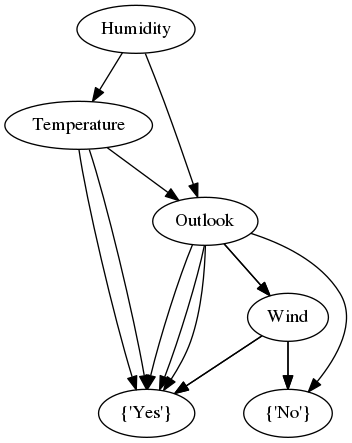

In [14]:
from anytree.exporter import DotExporter
from PIL import Image
# graphviz needs to be installed for the next line!
DotExporter(root_node).to_picture("udo.png")
Image.open("udo.png")